# CNN모델

In [53]:
import pandas as pd
import numpy as np
import re
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from konlpy.tag import Okt
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import font_manager, rc



In [54]:
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

In [55]:
# CSV 파일 읽기
df = pd.read_csv("./라벨링완료된공지사항(수정본).csv") 

notice_names = df['title'].tolist()

# 전처리 함수 정의
def preprocess_text(text):
    # 특수문자 제거
    text = re.sub(r"[^\uAC00-\uD7A30-9a-zA-Z\s]", "", text)

    # 숫자 정보 제거
    text = re.sub(r'\d+', '', text)

    # 형태소 분석
    tagger = Okt()
    words = tagger.morphs(text)

    # 불용어 제거
    stop_words = ['필독', '학기', '학년', '도', '년', '제', '회', '월', '학부', '일', '차', '년도', '안내']  # 불용어 리스트
    words = [word for word in words if word not in stop_words]

    # 분석된 형태소들을 공백으로 결합하여 문장으로 반환
    text = ' '.join(words)

    return text


preprocessed_notice_names = [preprocess_text(notice_name) for notice_name in notice_names]

In [56]:
# 토크나이저 생성
tokenizer = Tokenizer()

# 토크나이저가 데이터를 학습
tokenizer.fit_on_texts(preprocessed_notice_names)

# 데이터를 시퀀스로 변환
sequences = tokenizer.texts_to_sequences(preprocessed_notice_names)

# 가장 긴 문장의 길이를 확인
max_sequence_length = max(len(s) for s in sequences)
print('가장 긴 문장의 길이:', max_sequence_length)

# 어휘 사전의 크기를 확인 (+1을 하는 이유는 0인덱스를 고려하기 때문입니다.)
vocab_size = len(tokenizer.word_index) + 1
print('어휘 사전의 크기:', vocab_size)

# 모든 문장을 가장 긴 문장의 길이로 패딩 처리
padded_X = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

가장 긴 문장의 길이: 29
어휘 사전의 크기: 6097


In [57]:
# TF-IDF 벡터화
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(preprocessed_notice_names)

tfidf_model = TfidfVectorizer().fit(preprocessed_notice_names)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['class'])

In [58]:
# 훈련 데이터 분리: train 데이터 80%, test 데이터 20%
X_train, X_test, y_train, y_test = train_test_split(padded_X, y, test_size=0.2, random_state=42)

In [59]:
# 타겟 변수 다중 클래스 원-핫 인코딩
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

In [60]:
# CNN 모델 생성
model = Sequential()
model.add(Embedding(vocab_size, 128, input_length=max_sequence_length))
model.add(Conv1D(64, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))

# 출력 뉴런의 개수와 활성화 함수를 클래스 개수에 따라 조정
num_classes = len(set(y))  # 클래스 개수 계산
if num_classes == 2:
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
else:
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [61]:
#모델 훈현
model.fit(X_train, y_train_encoded, epochs=10, batch_size=32, validation_data=(X_test, y_test_encoded), callbacks=[EarlyStopping(patience=3)])

Epoch 1/10
251/251 [==============================] - 3s 10ms/step - loss: 2.8482 - accuracy: 0.3416 - val_loss: 1.4579 - val_accuracy: 0.6720
Epoch 2/10
251/251 [==============================] - 3s 10ms/step - loss: 0.7313 - accuracy: 0.8386 - val_loss: 0.5533 - val_accuracy: 0.8812
Epoch 3/10
251/251 [==============================] - 2s 9ms/step - loss: 0.2123 - accuracy: 0.9563 - val_loss: 0.4048 - val_accuracy: 0.9111
Epoch 4/10
251/251 [==============================] - 2s 9ms/step - loss: 0.0755 - accuracy: 0.9878 - val_loss: 0.4003 - val_accuracy: 0.9096
Epoch 5/10
251/251 [==============================] - 2s 9ms/step - loss: 0.0329 - accuracy: 0.9953 - val_loss: 0.3711 - val_accuracy: 0.9166
Epoch 6/10
251/251 [==============================] - 2s 9ms/step - loss: 0.0189 - accuracy: 0.9976 - val_loss: 0.3581 - val_accuracy: 0.9236
Epoch 7/10
251/251 [==============================] - 2s 8ms/step - loss: 0.0122 - accuracy: 0.9985 - val_loss: 0.3635 - val_accuracy: 0.9236
Epoc

In [62]:
# year, month column 추가
df['year'] = df['time'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').year)
df['month'] = df['time'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').month)

df.head()

,Cid,title,hits,time,cluster,class,year,month
0,5,2019 국립중앙대(대만) 썸머스쿨 참가자 선발 안내,6077,2019-03-08,499,국제교류,2019,3
1,5,2019 봉갑대(대만) 썸머스쿨 참가자 선발,5374,2019-03-26,499,국제교류,2019,3
2,5,2019 실천대(대만) 썸머스쿨 참가자 선발,4810,2019-05-22,499,국제교류,2019,5
3,5,2019 중국 동북사범대 썸머스쿨 참가자 선발,821,2019-05-14,499,국제교류,2019,5
4,5,2019 중국 동북사범대 썸머스쿨 참가자 선발(2차),4768,2019-05-21,499,국제교류,2019,5


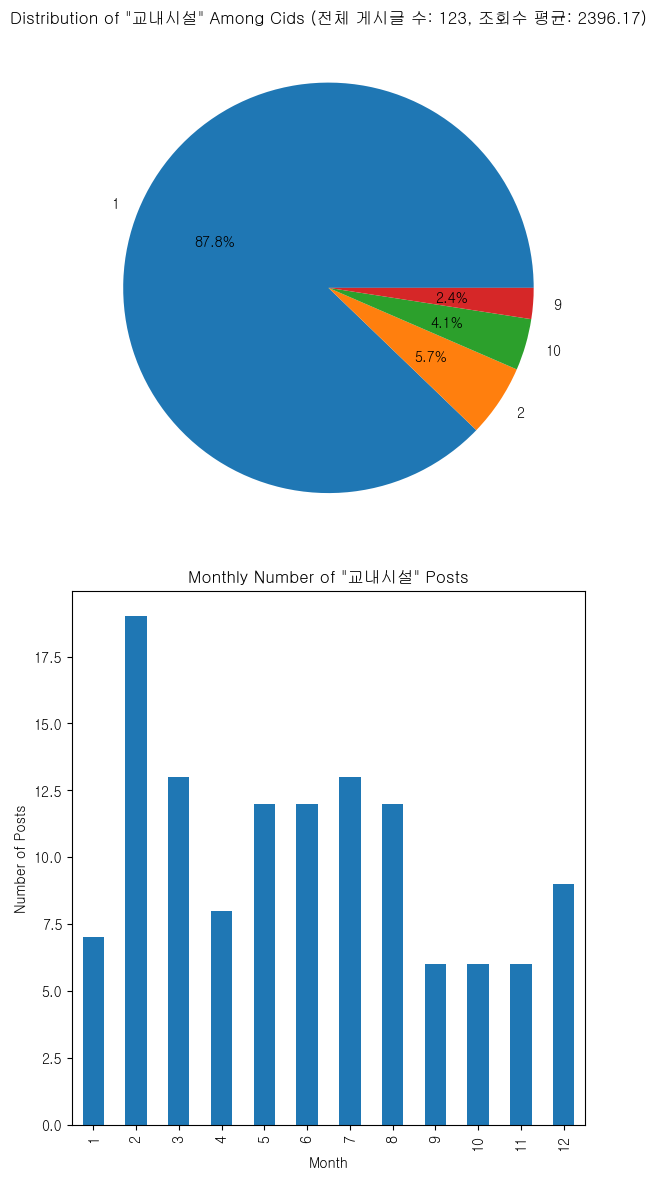

In [63]:
import matplotlib.pyplot as plt

def plot_class_distribution(df, keyword):
    # Filter dataframe by class keyword
    df_class = df[df['class'] == keyword]
    
    # Count the number of occurrences of each Cid
    cid_counts = df_class['Cid'].value_counts()

    # Total number of occurrences of the keyword
    total_count = df_class.shape[0]

    # Average hits for the keyword
    avg_hits = df_class['hits'].mean()

    # Count the number of occurrences of the keyword for each month
    monthly_counts = df_class['month'].value_counts().sort_index()

    # Plot a pie chart
    fig, axs = plt.subplots(2, 1, figsize=(6, 12))

    # Plot the Cid distribution
    axs[0].pie(cid_counts, labels=cid_counts.index, autopct='%1.1f%%')
    axs[0].set_title(f'Distribution of "{keyword}" Among Cids (전체 게시글 수: {total_count}, 조회수 평균: {avg_hits:.2f})')

    # Plot the monthly distribution
    monthly_counts.plot(kind='bar', ax=axs[1])
    axs[1].set_xlabel('Month')
    axs[1].set_ylabel('Number of Posts')
    axs[1].set_title(f'Monthly Number of "{keyword}" Posts')

    plt.tight_layout()
    plt.show()

# Test the function
plot_class_distribution(df, '교내시설')


1/1 [==============================] - 0s 42ms/step
입력 문장: 6월 7일 모의토익 고사장 및 성적 확인 방법 안내
예측된 레이블: 시험


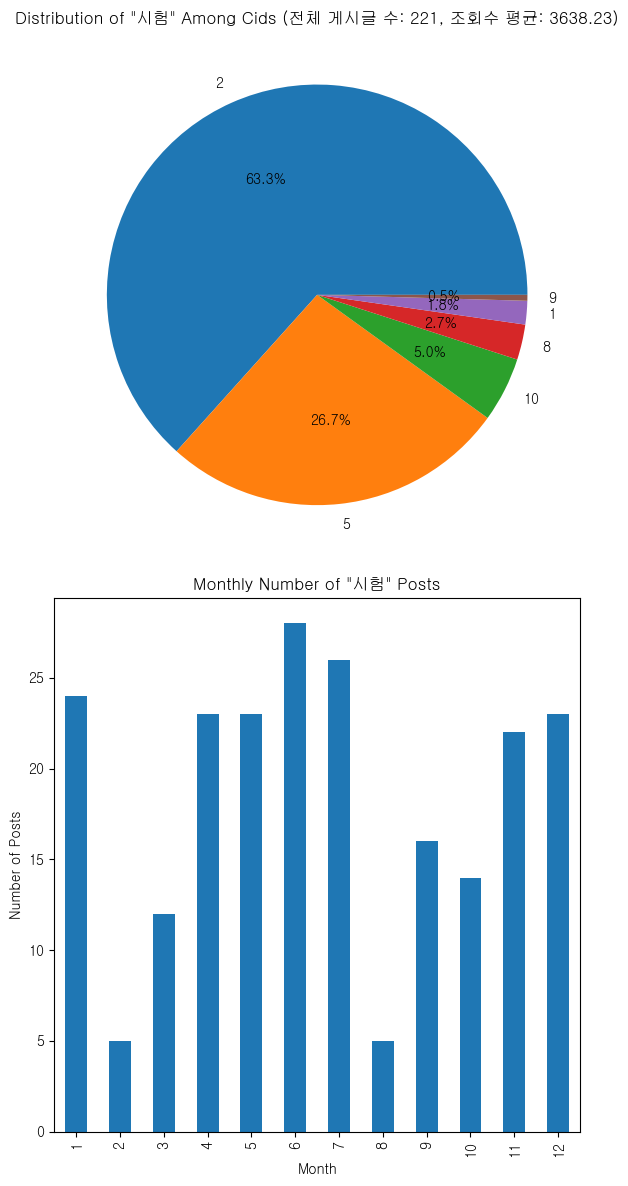

In [64]:
new_text = input("새로운 문장을 입력하세요: ")
preprocessed_new_text = preprocess_text(new_text)
sequence = tokenizer.texts_to_sequences([preprocessed_new_text])
padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length, padding='post')
prediction = model.predict(padded_sequence)
predicted_label = label_encoder.inverse_transform([prediction.argmax()])[0]

# 예측 결과 출력
print(f"입력 문장: {new_text}")
print(f"예측된 레이블: {predicted_label}")

# 해당 레이블의 분포를 그래프로 표시
plot_class_distribution(df, predicted_label)


In [65]:
y_prob = model.predict(X_test, verbose=0) 
y_pred = y_prob.argmax(axis=-1)
CNN_accuracy = np.sum(y_pred.flatten() == y_test) / len(y_test)
print("Accuracy:", CNN_accuracy)

Accuracy: 0.9231153270094857


# LSTM모델

In [66]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from konlpy.tag import Okt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, LSTM

In [67]:
# CSV 파일 읽기
df = pd.read_csv("./라벨링완료된공지사항(수정본).csv") 

notice_names = df['title'].tolist()

# 전처리 함수 정의
def preprocess_text(text):
    # 특수문자 제거
    text = re.sub(r"[^\uAC00-\uD7A30-9a-zA-Z\s]", "", text)

    # 숫자 정보 제거
    text = re.sub(r'\d+', '', text)

    # 형태소 분석
    tagger = Okt()
    words = tagger.morphs(text)

    # 불용어 제거
    stop_words = ['필독', '학기', '학년', '도', '년', '제', '회', '월', '학부', '일', '차', '년도', '안내']  # 불용어 리스트
    words = [word for word in words if word not in stop_words]

    # 분석된 형태소들을 공백으로 결합하여 문장으로 반환
    text = ' '.join(words)

    return text


preprocessed_notice_names = [preprocess_text(notice_name) for notice_name in notice_names]

In [68]:
# TF-IDF 벡터화
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(preprocessed_notice_names)

tfidf_model = TfidfVectorizer().fit(preprocessed_notice_names)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['class'])

In [69]:
# 토크나이저 생성
tokenizer = Tokenizer()

# 토크나이저가 데이터를 학습
tokenizer.fit_on_texts(preprocessed_notice_names)

# 데이터를 시퀀스로 변환
sequences = tokenizer.texts_to_sequences(preprocessed_notice_names)

# 가장 긴 문장의 길이를 확인
max_sequence_length = max(len(s) for s in sequences)
print('가장 긴 문장의 길이:', max_sequence_length)

# 어휘 사전의 크기를 확인 (+1을 하는 이유는 0인덱스를 고려하기 때문입니다.)
vocab_size = len(tokenizer.word_index) + 1
print('어휘 사전의 크기:', vocab_size)

# 모든 문장을 가장 긴 문장의 길이로 패딩 처리
padded_X = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

가장 긴 문장의 길이: 29
어휘 사전의 크기: 6097


In [70]:
# TF-IDF 벡터화
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(preprocessed_notice_names)

tfidf_model = TfidfVectorizer().fit(preprocessed_notice_names)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['class'])

In [71]:
# 훈련 데이터 분리: train 데이터 80%, test 데이터 20%
X_train, X_test, y_train, y_test = train_test_split(padded_X, y, test_size=0.2, random_state=42)

In [72]:
# 타겟 변수 다중 클래스 원-핫 인코딩
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

In [73]:
# LSTM 모델 생성
model = Sequential()
model.add(Embedding(vocab_size, 128, input_length=max_sequence_length))
model.add(LSTM(64))
model.add(Dense(64, activation='relu'))

# 출력 뉴런의 개수와 활성화 함수를 클래스 개수에 따라 조정
num_classes = len(set(y))  # 클래스 개수 계산
if num_classes == 2:
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
else:
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [74]:
# 모델 훈련
model.fit(X_train, y_train_encoded, epochs=50, batch_size=32, validation_data=(X_test, y_test_encoded))

Epoch 1/50
251/251 [==============================] - 6s 15ms/step - loss: 3.7164 - accuracy: 0.0856 - val_loss: 3.3535 - val_accuracy: 0.0884
Epoch 2/50
251/251 [==============================] - 4s 14ms/step - loss: 3.0649 - accuracy: 0.1488 - val_loss: 2.8679 - val_accuracy: 0.1882
Epoch 3/50
251/251 [==============================] - 3s 13ms/step - loss: 2.6036 - accuracy: 0.2252 - val_loss: 2.5473 - val_accuracy: 0.2346
Epoch 4/50
251/251 [==============================] - 3s 12ms/step - loss: 2.2402 - accuracy: 0.3208 - val_loss: 2.4303 - val_accuracy: 0.3250
Epoch 5/50
251/251 [==============================] - 3s 12ms/step - loss: 1.9094 - accuracy: 0.4212 - val_loss: 2.0252 - val_accuracy: 0.4234
Epoch 6/50
251/251 [==============================] - 3s 12ms/step - loss: 1.5161 - accuracy: 0.5311 - val_loss: 1.7292 - val_accuracy: 0.5367
Epoch 7/50
251/251 [==============================] - 3s 13ms/step - loss: 1.2032 - accuracy: 0.6218 - val_loss: 1.5411 - val_accuracy: 0.5861

In [75]:
y_prob = model.predict(X_test, verbose=0) 
y_pred = y_prob.argmax(axis=-1)
LSTM_accuracy = np.sum(y_pred.flatten() == y_test) / len(y_test)
print("Accuracy:", LSTM_accuracy)

Accuracy: 0.8701947079380928


# 성능 비교 시각화

In [76]:
import matplotlib.pyplot as plt

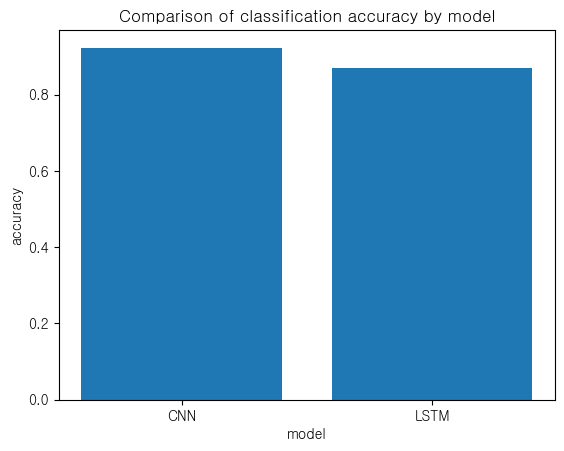

In [77]:
#그래프로 성능 비교 

x = ('CNN', 'LSTM')
y = [CNN_accuracy, LSTM_accuracy]
plt.xlabel("model")
plt.ylabel("accuracy")
plt.bar(x, y)  # 데이터 가로 나온 함수 barh
plt.title('Comparison of classification accuracy by model')

plt.show()
